In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import DistanceMetric
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pylab as plt
import seaborn as sns
import umap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd

df_test_raw = pd.read_csv('../common/data/adult_test.csv',
                    sep=',',
                    engine='python')

df_train_raw = pd.read_csv('../common/data/adult_train.csv',
                    sep=',',
                    engine='python')

df_cf_raw = pd.read_csv('../common/cfs/baseline.csv',
                    sep=',',
                    engine='python')

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [14]:
categorical_cols = df_train_raw.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_train_raw.select_dtypes(exclude=['object']).columns.tolist()

In [15]:
class DataPreprocessor:
    def __init__(self, numerical_cols, categorical_cols):
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.scaler = MinMaxScaler()

    def preprocess(self, df):
        df[self.numerical_cols] = self.scaler.fit_transform(df[self.numerical_cols])
        new_dummy_cols = pd.get_dummies(df, columns=self.categorical_cols).columns.difference(df.columns)
        df = pd.get_dummies(df, columns=self.categorical_cols)
        df[new_dummy_cols] = df[new_dummy_cols].astype(int)
        return df

    def inverse_preprocess(self, df):
        # Reverse one-hot encoding
        for col in self.categorical_cols:
            one_hot_cols = [c for c in df.columns if c.startswith(col + '_')]
            df[col] = df[one_hot_cols].idxmax(axis=1).apply(lambda x: x[len(col) + 1:])
            df.drop(columns=one_hot_cols, inplace=True)
        
        df[self.numerical_cols] = self.scaler.inverse_transform(df[self.numerical_cols])
        return df

preprocessor = DataPreprocessor(numerical_cols, categorical_cols)
df_test = preprocessor.preprocess(df_test_raw.copy())
df_cf = preprocessor.preprocess(df_cf_raw.copy())

In [ ]:
sns.pairplot(df_test_raw)

In [2]:
plot_umap_grid(df_test, 
               hue_data=df_test_raw['sex'],
               n_neighbors_values=[5, 15, 30],
               min_dist_values=[0.1, 0.5, 0.9],
            )

ModuleNotFoundError: No module named 'utils'

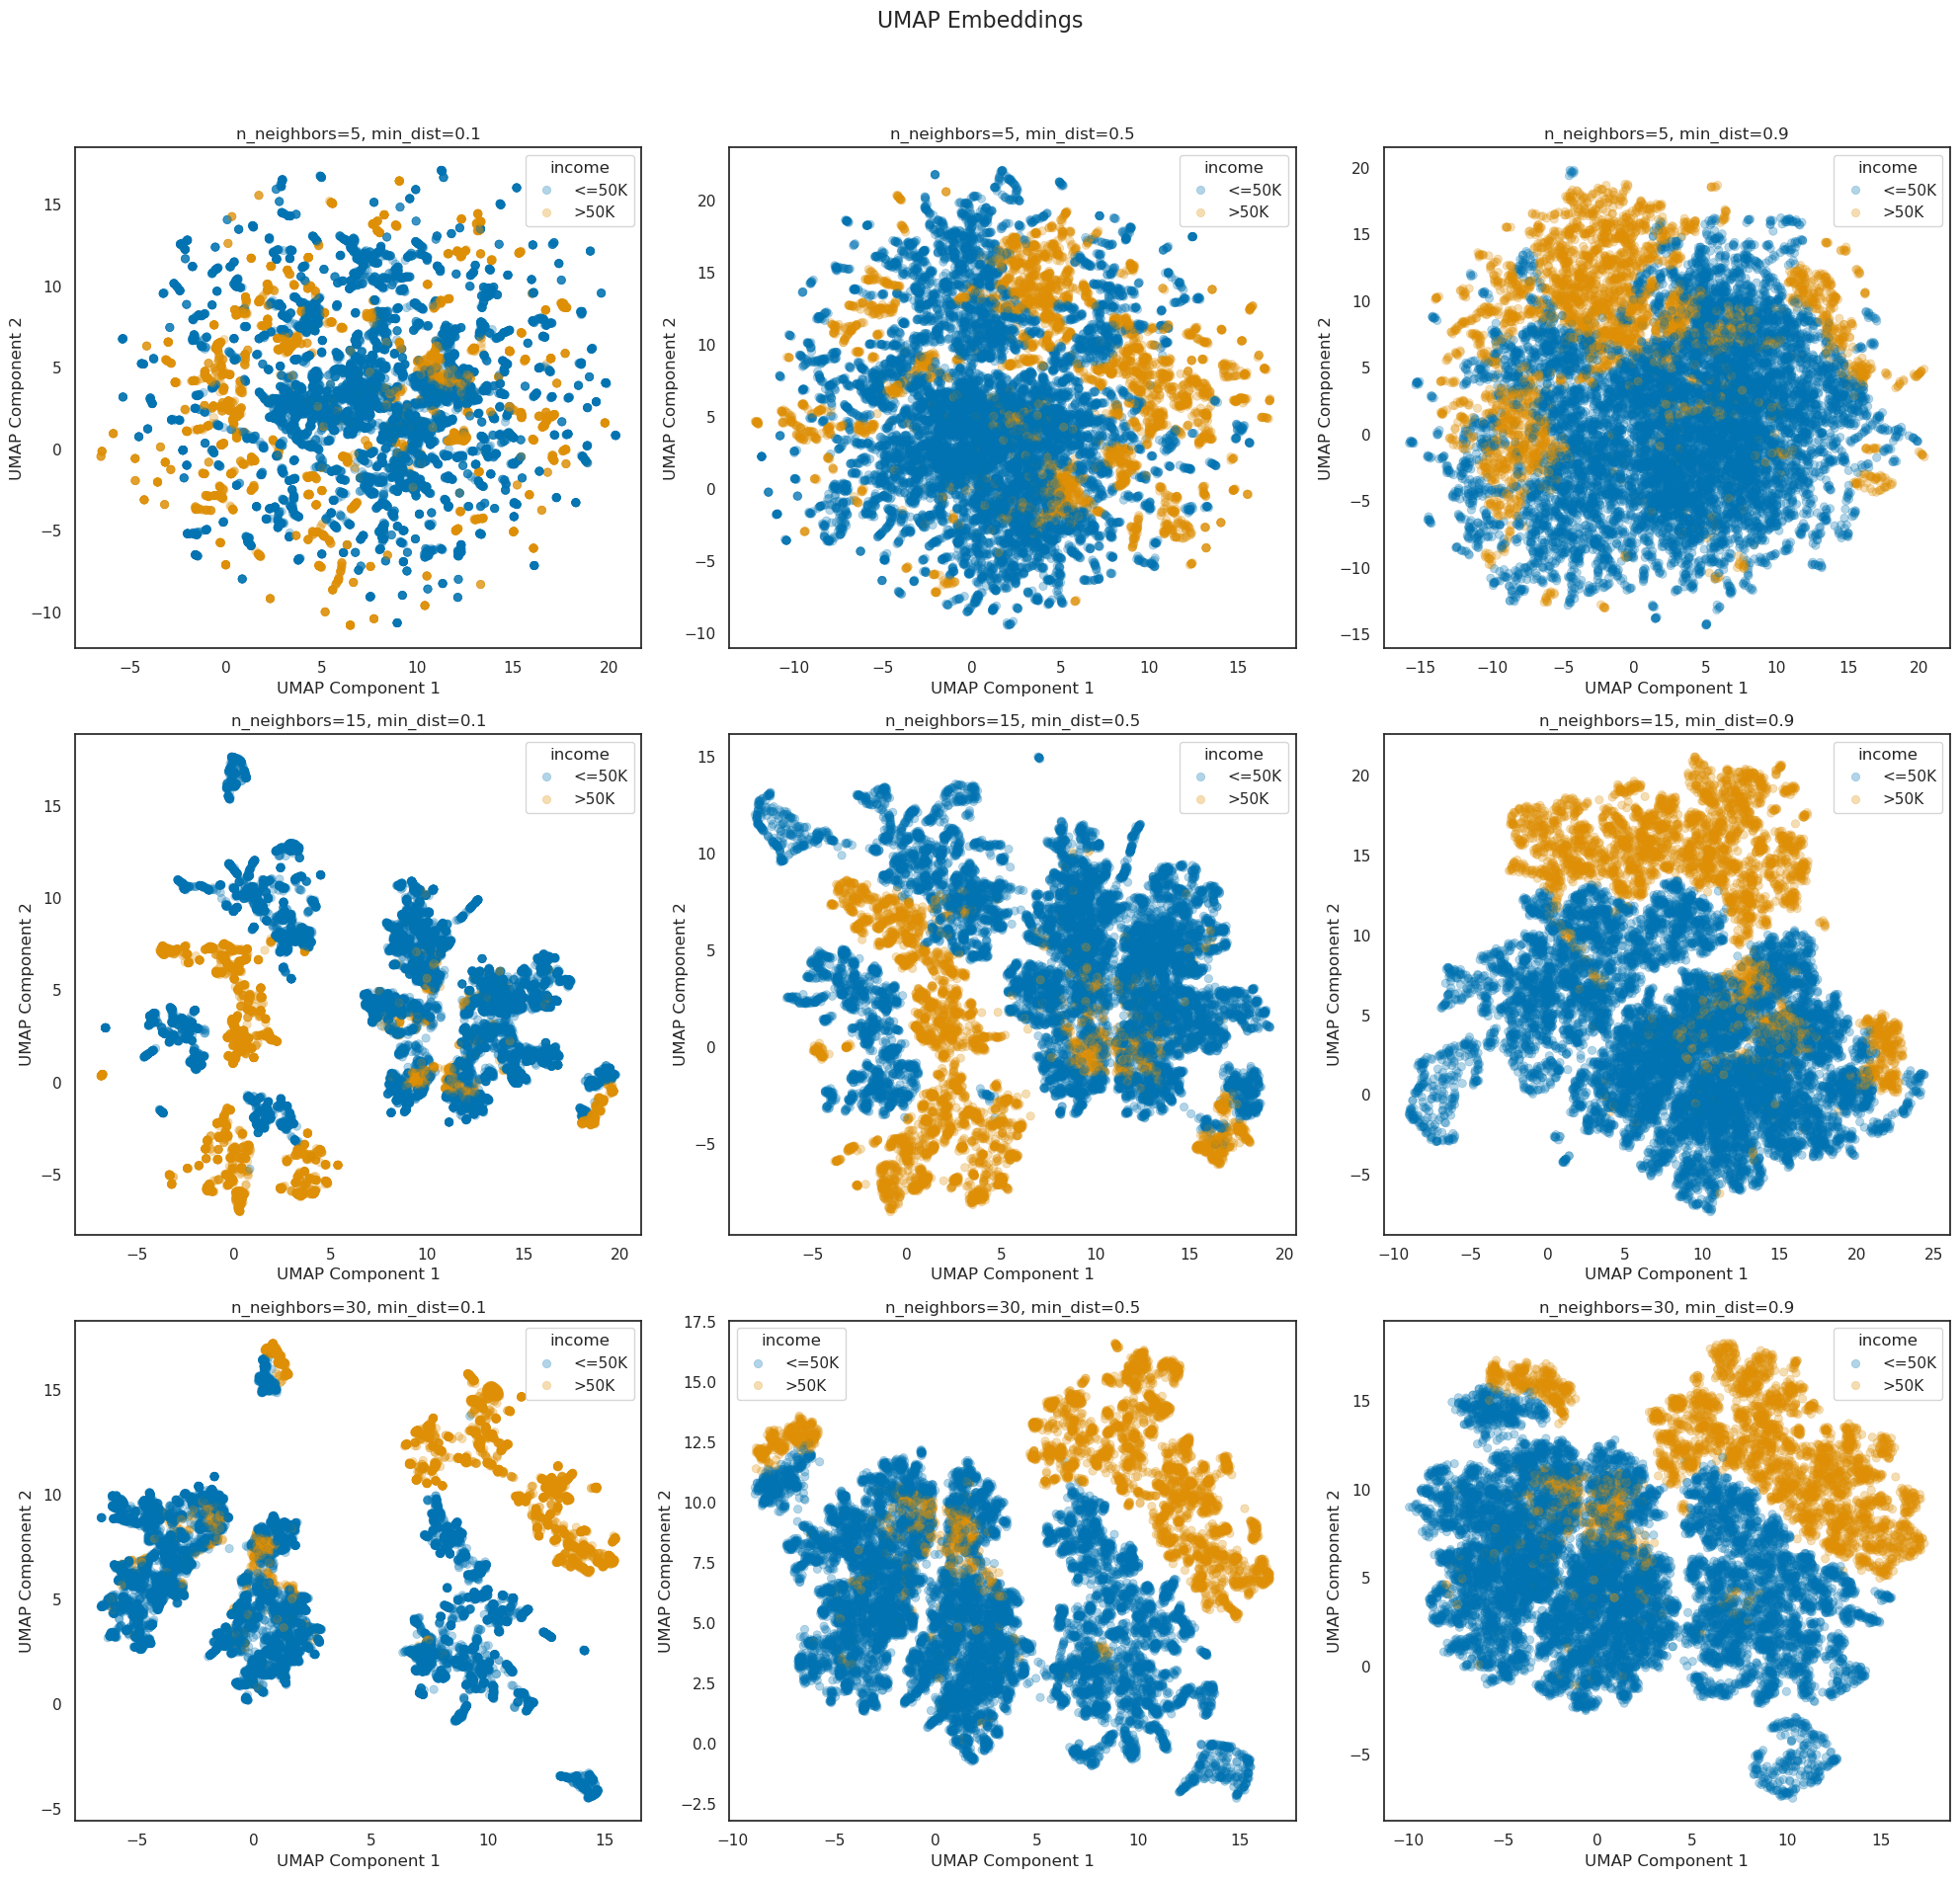

In [29]:
plot_umap_grid(df_test, 
               hue_data=df_test_raw['income'],
               n_neighbors_values=[5, 15, 30],
               min_dist_values=[0.1, 0.5, 0.9],
            )

/home/dgvalerio/miniconda3/envs/sandbox/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


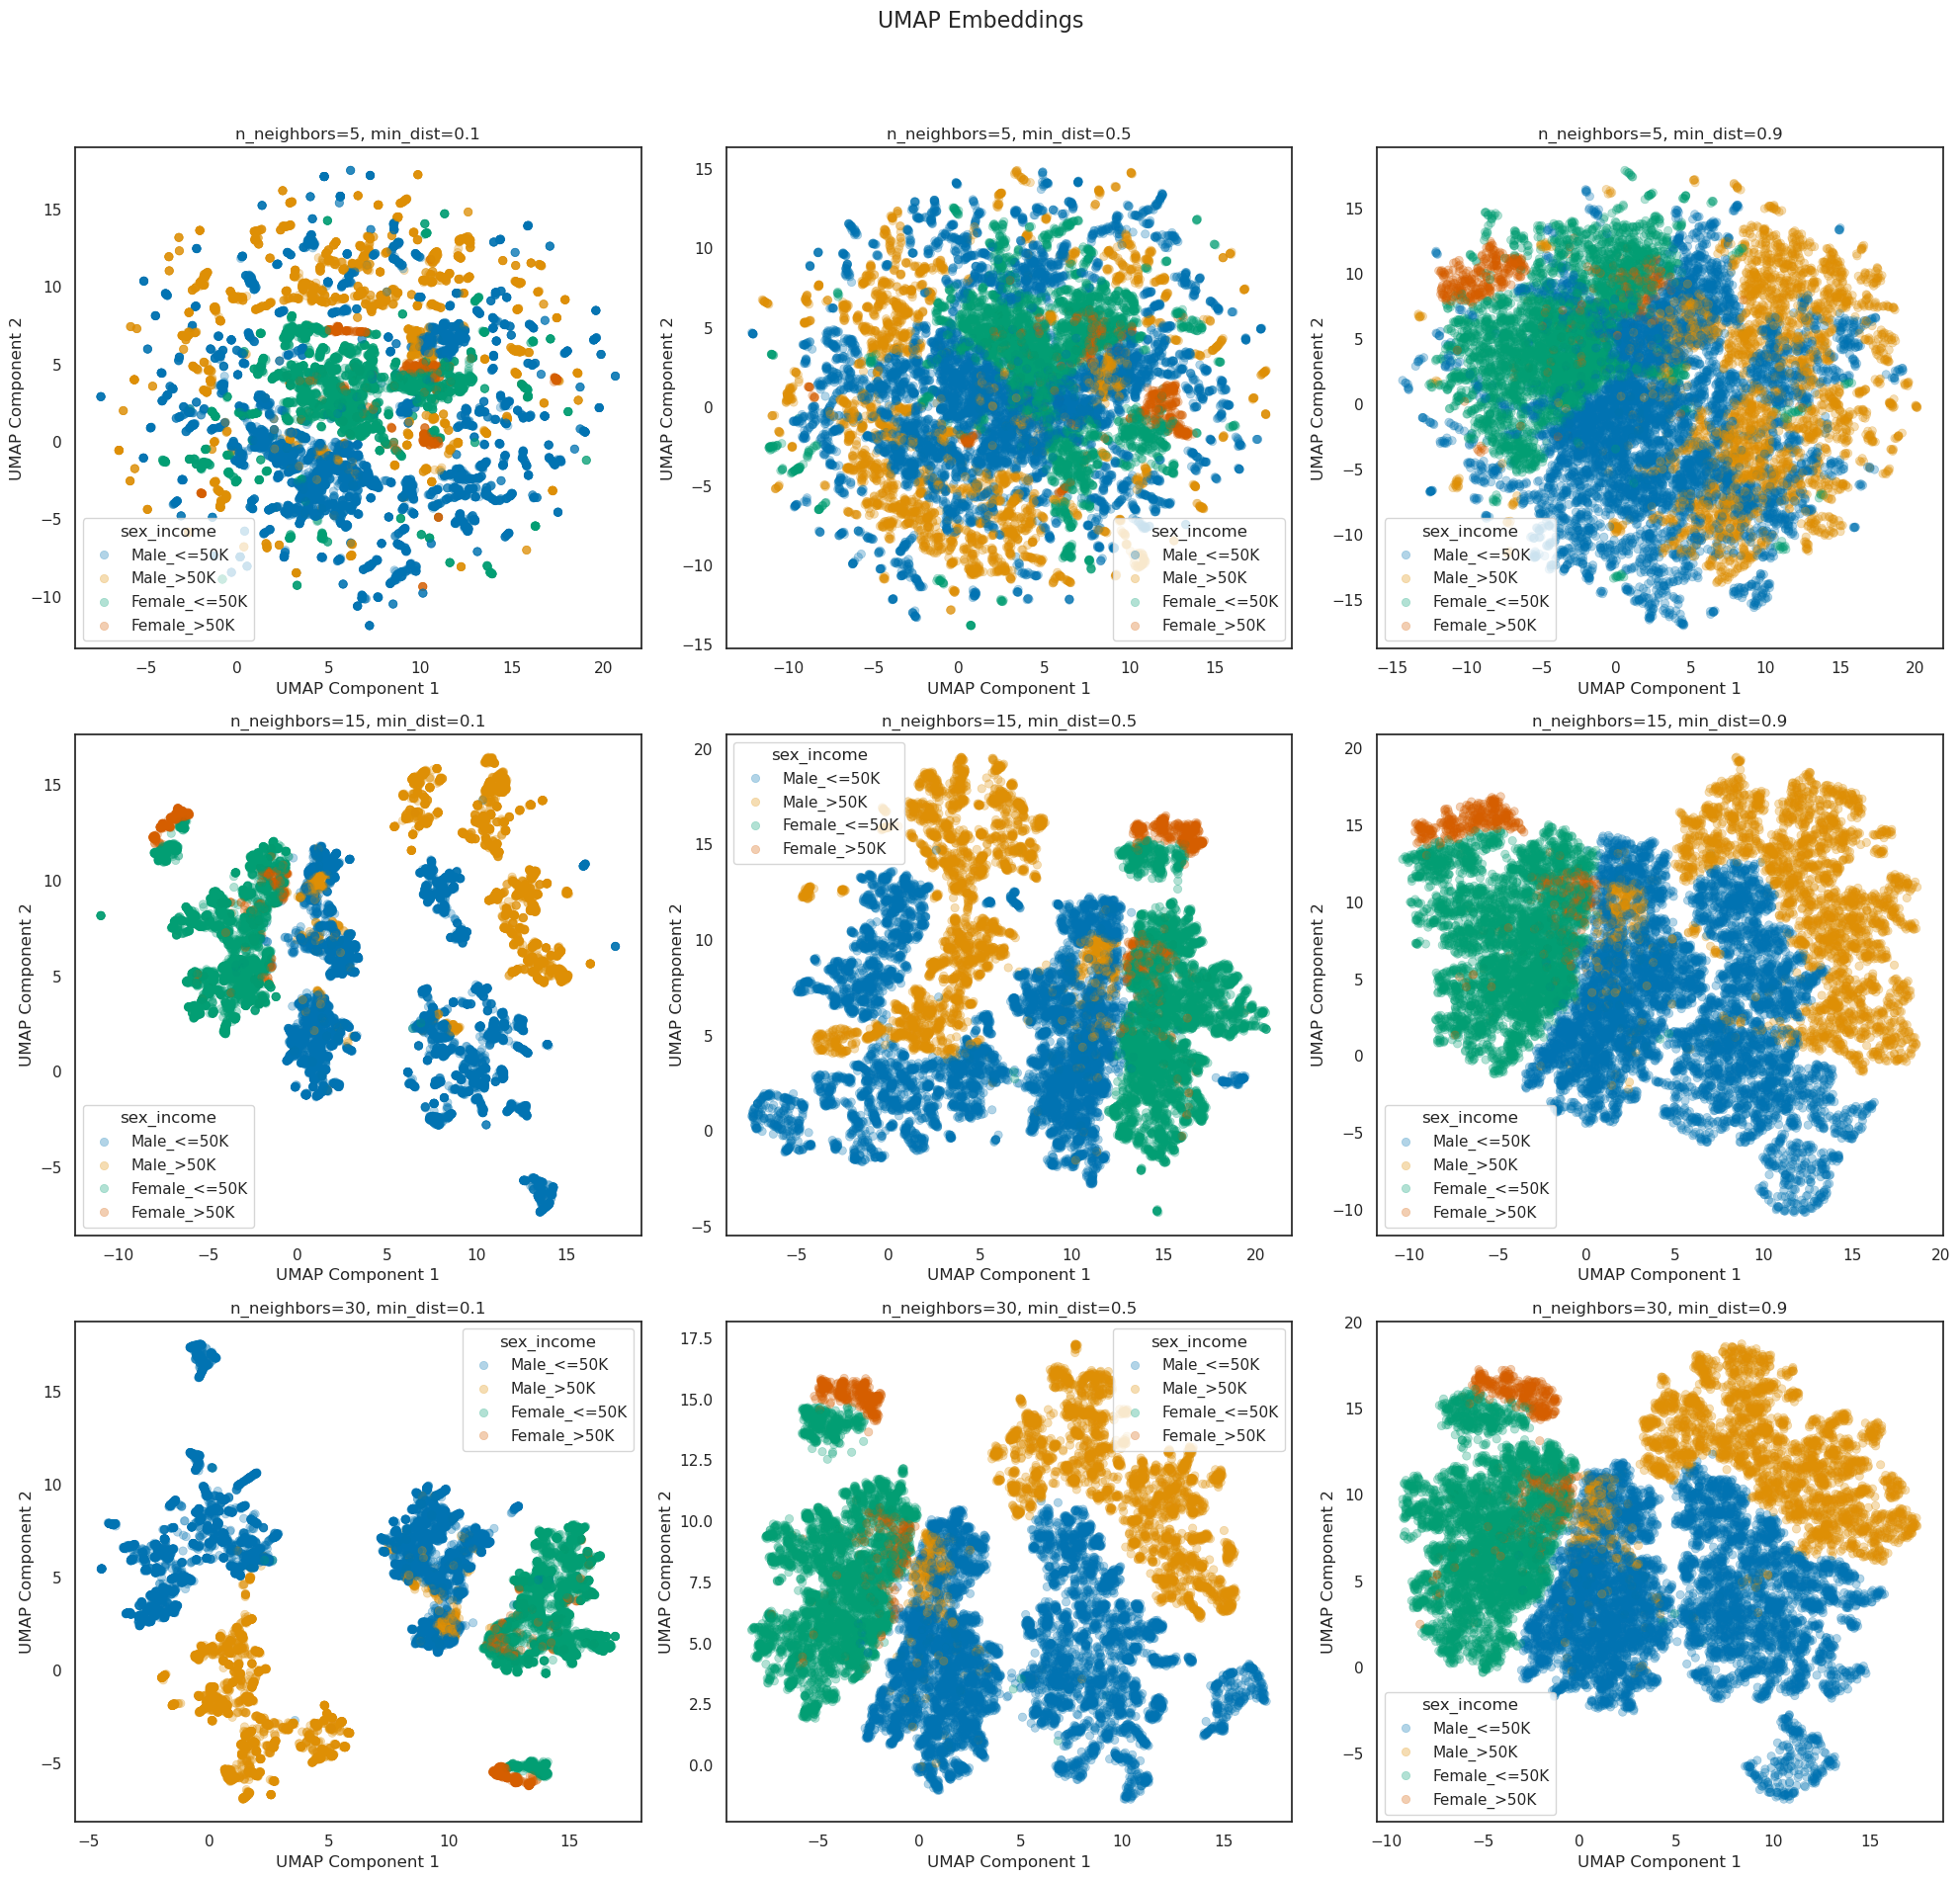

In [33]:
df_test_raw['sex_income'] = df_test_raw['sex'] + '_' + df_test_raw['income']
plot_umap_grid(df_test, 
               hue_data=df_test_raw['sex_income'],
               n_neighbors_values=[5, 15, 30],
               min_dist_values=[0.1, 0.5, 0.9],
            )

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Fit the model and predict the LOF scores
lof_scores = -lof.fit_predict(df_test)

# Add the LOF scores to the dataframe
df_test['LOF_Score'] = lof_scores

# Display the dataframe with LOF scores
print(df_test[['LOF_Score']])

In [ ]:
sensitive_cols_ohe = ['sex_Male', 'sex_Female']
distances = calculate_distance_fact_cf(df_test[:100].drop(columns=sensitive_cols_ohe),
                        df_cf[:100].drop(columns=sensitive_cols_ohe),
                        'cosine')

In [ ]:
from profile_data import plot_categorical_distribution
for col in categorical_columns:
    plot_categorical_distribution(df_train, col, 'sex') 

In [ ]:
from profile_data import plot_continuous_distribution
for col in numerical_columns:
    plot_continuous_distribution(df_fact, col, 'sex')